# <center> Классификация сигналов оптомиографических датчиков

In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('bmh')

from sklearn import preprocessing
from sklearn import metrics
from sklearn import svm
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from keras import callbacks

import warnings
warnings.filterwarnings('ignore')

In [3]:
# факторы
X = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')

# целевые переменные
Y = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/sample_submission.csv')

print(X.shape, Y.shape)
print(X_test.shape, y_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100) (5400, 2)


Как видим, они упакованы в 3D-массивы. Для дальнейшей работы нам необходимо их развернуть.

In [4]:
X_2d = np.zeros((0, 40))
X_test_2d = np.zeros((0, 40))

for i in range(X.shape[0]):
    X_2d = np.vstack((X_2d, X[i].T))
    
for i in range(X_test.shape[0]):
    X_test_2d = np.vstack((X_test_2d, X_test[i].T))  

    
X_2d.shape, X_test_2d.shape

((32300, 40), (5400, 40))

Сформируем из получившихся данных соответствующие датафреймы.

In [5]:
X_2d_df = pd.DataFrame(X_2d)
X_2d_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,1877.0,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0
1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,1876.0,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0
2,1121.0,17.0,1444.0,60.0,32.0,1732.0,141.0,10.0,1065.0,14.0,...,1878.0,77.0,14.0,1169.0,130.0,30.0,1670.0,29.0,727.0,27.0


In [6]:
X_test_2d_df = pd.DataFrame(X_test_2d)
X_test_2d_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1681.0,4.0,1834.0,33.0,26.0,2254.0,43.0,0.0,1376.0,27.0,...,1635.0,82.0,16.0,1204.0,108.0,25.0,1685.0,27.0,386.0,25.0
1,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,1643.0,71.0,19.0,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0
2,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,1658.0,72.0,15.0,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0


Оценим соотношение классов в `y_train`.

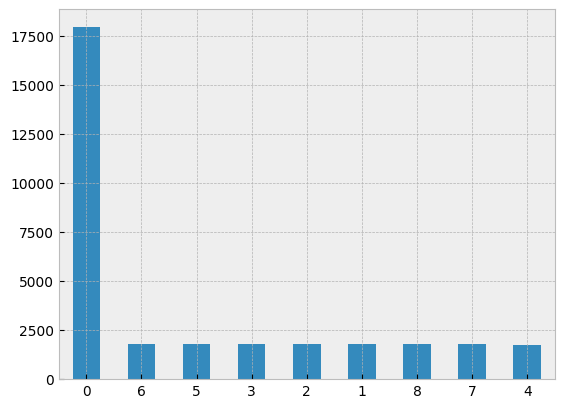

In [7]:
Y_2d = Y['class']

Y_2d.value_counts().plot(kind="bar", rot=0.5);

Y_2d = Y_2d.values

Класс `0`, как видим, представлен в данных на порядок чаще.

`y_train.csv` содержит следующие классы:
  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab";¶

### Исходный вид

In [8]:
y_train_original = Y.copy()

y_train_original[['sample_id', 'timestep']] = y_train_original['sample-timestep'].str.split(pat="-", n=1, expand=True).astype(int)
y_train_original = y_train_original.pivot(index='sample_id', columns='timestep', values='class')
Y_index = Y.index
y_train_original = y_train_original.sort_index() # на всякий случай
y_train_original = y_train_original.values

print(y_train_original.shape)
y_train_original

(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

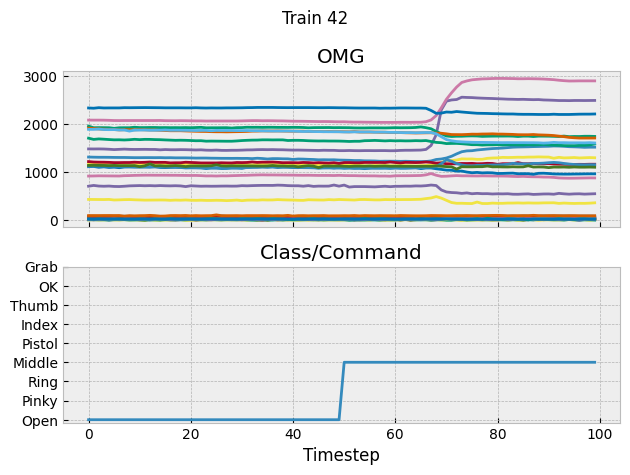

In [9]:
# Номер страницы в 3d-массиве
i = 42
# Объявим лейблы жестов
GESTURES = ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']

fig, axx = plt.subplots(2, 1, sharex=True)
axx[0].plot(X[i].T)
axx[0].set_title('OMG')
axx[1].plot(y_train_original[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(np.arange(9), GESTURES)
plt.suptitle(f'Train {i}')
plt.tight_layout()

In [10]:
# Функция для отрисовки графики "OMG and Protocol" для заданного интервала
def get_graphs(X_array, y_array, start=1000, end=1500):
    
    _, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    plt.grid(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

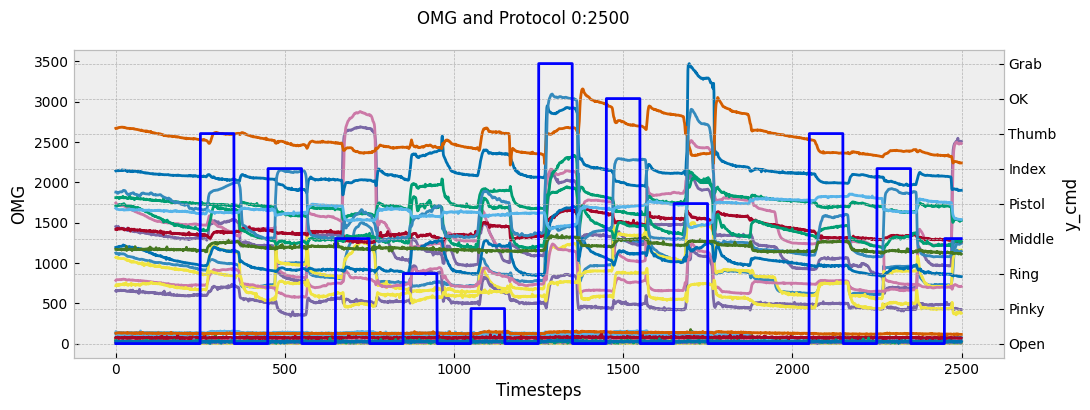

In [11]:
get_graphs(X_2d, Y_2d, start=0, end=2500)

---
---
## Препроцессинг

### Устранение лага между сигналами датчиков и таргетом

In [14]:
def get_naive_centering(X_arr, y_arr, gap=500, inter=1000, window=30, use_m=True, model=svm.SVC()):
    """Функция для устранения глобального лага между сигналами датчиков и таргетом.

    Args:
        X_arr (ndarray): Массив данных.
        y_arr (ndarray): Вектор целевого признака.
        gap (int, optional): Размеры концевых отступов. Defaults to 500.
        inter (int, optional): Величина концевых выборок. Defaults to 1000.
        window (int, optional): Величина окна поиска оптимального сдвига. Defaults to 20.
        use_m (bool, optional): Использование модели для поиска оптимального сдвига.
            Defaults to True. False: поиск сдвига по корреляции таргета с вектором
            суммы модулей дифференциалов векторов признаков массива данных.
        model (abc.ABCMeta, optional): Алгоритм scikit-learn. Defaults to svm.SVC().

    Returns:
        tuple():
            ndarray: Вектор сдвинутого таргета.
            list: Строки отчета по проделанным операциям.
    """
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    def get_diff(X):
        return pd.DataFrame(X).diff().abs().sum(axis=1)
        # return np.sum(np.abs(np.diff(X)), axis=1)
    
    # Функция для сдвига таргета
    def shifter(y_arr, shift=1):
        first_element = y_arr[0]
        prefix = np.full(shift, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-shift]
    
        return y_arr_shifted
    
    # Функция для расчета точности модели
    def get_score(X, y, model=model):
        X = get_diff(X).values.reshape(-1, 1)
        model = model
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    # Функция для расчета корреляции
    def get_corr(X, y):
        x_diff = get_diff(X)
        correlation = np.corrcoef(x_diff, y)[0, 1]
        
        return abs(correlation)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    s1, s2 = 1, 1
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, shift=i)
        y_b = shifter(y_part2, shift=i)
        
        if use_m:
            current_score1 = get_score(X_part1, y_a)
            current_score2 = get_score(X_part2, y_b)
        else:
            current_score1 = get_corr(X_part1, y_a)
            current_score2 = get_corr(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            s1 = i
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            s2 = i
    
    optimal_shift = round((s1+s2)/2)
    y_arr_shifted = shifter(y_arr, shift=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок:   {s1} и {s2}\n',
        f'Accuracy/correlation на концевых выборках: {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига (как среднего): {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

In [15]:
# Выберем алгоритм для поиска смещения
fitting_model = svm.LinearSVC(dual='auto') # м/б использовано, если use_m=True
y_shifted, summary = get_naive_centering(X_2d, Y_2d, use_m=False, window=30, model=fitting_model)

print('Test sample shifting\n', *summary, sep='')

Test sample shifting
Оптимальные свдиги для концевых выборок:   19 и 18
Accuracy/correlation на концевых выборках: 0.2098838604340627; 0.05427119189935997
Размер оптимального сдвига (как среднего): 18


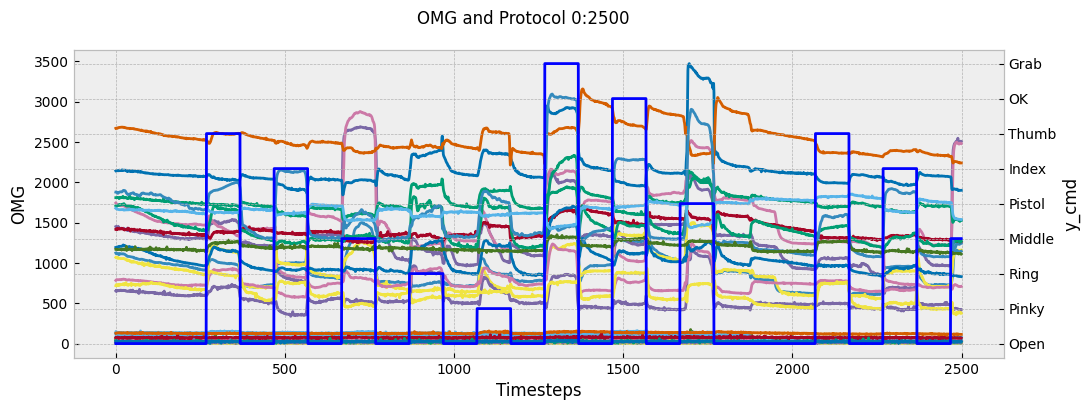

In [16]:
get_graphs(X_2d, y_shifted, start=0, end=2500)

Удалось скорректировать данные относительно таргета.

### Сэмплирование

Рассчитаем размер валидационной выборки

In [18]:
print(f'20% от X: {int(X_2d.shape[0] * 0.2)}')

20% от X: 6460


Таким образом, последний индекс трейн-выборки:

In [19]:
last_train_idx = X_2d.shape[0] - 6860
last_train_idx

25440

И, наконец, сэмплируем.

In [20]:
X_train_2d = X_2d[:last_train_idx]
X_valid_2d = X_2d[last_train_idx:]

y_train_2d = y_shifted[:last_train_idx]
y_valid_2d = y_shifted[last_train_idx:]

print(X_train_2d.shape, y_train_2d.shape)
print(X_valid_2d.shape, y_valid_2d.shape)

(25440, 40) (25440,)
(6860, 40) (6860,)


### Нормализация

In [21]:
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train_2d)
X_valid_mm = mm_scaler.transform(X_valid_2d)
X_test_mm = mm_scaler.transform(X_test_2d)

---
---
## Моделирование

In [54]:
duration = 40
ts_events = np.arange(0, len(X_train_mm), duration)

y_train_nn = tf.keras.utils.to_categorical(y_train_2d)
y_valid_nn = tf.keras.utils.to_categorical(y_valid_2d)

X_train_nn = [X_train_mm[ts_event : ts_event + duration] for ts_event in ts_events]
y_train_nn = [y_train_nn[ts_event : ts_event + duration] for ts_event in ts_events]

X_valid_nn = [X_valid_mm[ts_event : ts_event + duration] for ts_event in ts_events]
y_valid_nn = [y_valid_nn[ts_event : ts_event + duration] for ts_event in ts_events]

X_train_nn = np.array([arr for arr in X_train_nn if arr.shape == X_train_nn[0].shape])
y_train_nn = np.array([arr for arr in y_train_nn if arr.shape == y_train_nn[0].shape])

X_valid_nn = np.array([arr for arr in X_valid_nn if arr.shape == X_valid_nn[0].shape])
y_valid_nn = np.array([arr for arr in y_valid_nn if arr.shape == y_valid_nn[0].shape])

print(X_train_nn.shape, y_train_nn.shape)
print(X_valid_nn.shape, y_valid_nn.shape)

(636, 40, 40) (636, 40, 9)
(171, 40, 40) (171, 40, 9)


In [77]:
_, n_timesteps, n_channels = X_train_nn.shape
output_units = y_train_nn.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(None, n_channels))

x = tf.keras.layers.GRU(units=128, return_sequences=True, dropout=0.3)(x)
x = tf.keras.layers.GRU(units=32, return_sequences=True, dropout=0.1)(x)

output = tf.keras.layers.Dense(units=output_units, activation='softmax')(x)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

model.summary()

input_shape = (40, 40) | output_units = 9
Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, 40)]        0         
                                                                 
 gru (GRU)                   (None, None, 128)         65280     
                                                                 
 gru_1 (GRU)                 (None, None, 32)          15552     
                                                                 
 dense_6 (Dense)             (None, None, 9)           297       
                                                                 
Total params: 81129 (316.91 KB)
Trainable params: 81129 (316.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
model.compile(
    loss="categorical_crossentropy",
    metrics=[Precision(), Recall()],
    optimizer=tf.keras.optimizers.experimental.Adam()
)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min", patience=50,
    restore_best_weights=True
)

his = model.fit(
    X_train_nn,
    y_train_nn,
    batch_size=8,
    epochs=1000,
    verbose=1,
    validation_data=(X_valid_nn, y_valid_nn),
    callbacks=[earlystopping]
)

Epoch 1/1000
80/80 [==============================] - 4s 20ms/step - loss: 1.4825 - precision_5: 0.6866 - recall_5: 0.4114 - val_loss: 1.0547 - val_precision_5: 0.7609 - val_recall_5: 0.5126
Epoch 2/1000
80/80 [==============================] - 1s 13ms/step - loss: 0.8934 - precision_5: 0.8638 - recall_5: 0.5803 - val_loss: 0.6531 - val_precision_5: 0.9099 - val_recall_5: 0.6721
Epoch 3/1000
80/80 [==============================] - 1s 13ms/step - loss: 0.6695 - precision_5: 0.8901 - recall_5: 0.6703 - val_loss: 0.5057 - val_precision_5: 0.9387 - val_recall_5: 0.7661
Epoch 4/1000
80/80 [==============================] - 1s 13ms/step - loss: 0.5564 - precision_5: 0.9012 - recall_5: 0.7565 - val_loss: 0.4163 - val_precision_5: 0.9466 - val_recall_5: 0.8709
Epoch 5/1000
80/80 [==============================] - 1s 13ms/step - loss: 0.5027 - precision_5: 0.9035 - recall_5: 0.7921 - val_loss: 0.4056 - val_precision_5: 0.9242 - val_recall_5: 0.8538
Epoch 6/1000
80/80 [=========================

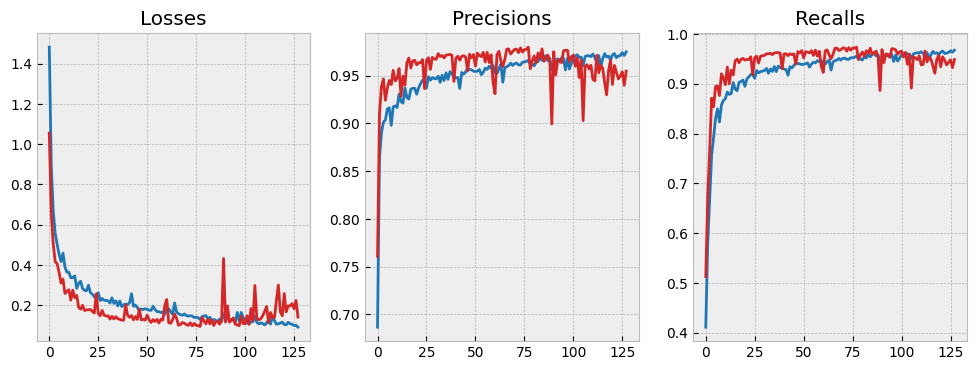

In [79]:
history_keys = list(his.history.keys())

# Создаем подграфики
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 строка, 3 столбца

# Строим графики
axs[0].plot(his.history['loss'], color='tab:blue')
axs[0].plot(his.history['val_loss'], color='tab:red')
axs[0].set_title('Losses')

axs[1].plot(his.history[history_keys[1]], color='tab:blue')
axs[1].plot(his.history[history_keys[4]], color='tab:red')
axs[1].set_title('Precisions')

axs[2].plot(his.history[history_keys[2]], color='tab:blue')
axs[2].plot(his.history[history_keys[5]], color='tab:red')
axs[2].set_title('Recalls')

# Отображаем графики
plt.show()

In [80]:
y_pred_train_nn = model.predict(X_train_nn)
print(y_pred_train_nn.shape)

20/20 [==============================] - 1s 5ms/step
(636, 40, 9)


In [81]:
y_pred_train = [arr.argmax(axis=-1) for arr in y_pred_train_nn]

y_pred_train_t = tf.constant(y_pred_train, shape=(636, 40)).numpy()

preds_train = []
for idx, arr in zip(y_train_2d, y_pred_train_t):
    series = pd.Series(arr)
    preds_train.append(series)
    
preds_train = pd.concat(preds_train)
preds_train = preds_train.reset_index().drop('index', axis=1).values

print(metrics.classification_report(y_train_2d, preds_train, digits=4))

              precision    recall  f1-score   support

           0     0.9690    0.9934    0.9810     14240
           1     0.9788    0.9543    0.9664      1400
           2     0.9941    0.9671    0.9804      1400
           3     0.9942    0.9750    0.9845      1400
           4     0.9903    0.9521    0.9709      1400
           5     0.9562    0.9657    0.9609      1400
           6     0.9900    0.9186    0.9529      1400
           7     0.9755    0.9114    0.9424      1400
           8     0.9949    0.9764    0.9856      1400

    accuracy                         0.9754     25440
   macro avg     0.9826    0.9571    0.9694     25440
weighted avg     0.9757    0.9754    0.9753     25440



In [82]:
y_pred_valid_nn = model.predict(X_valid_nn)
print(y_pred_valid_nn.shape)

6/6 [==============================] - 0s 5ms/step
(171, 40, 9)


In [83]:
y_pred_valid = [arr.argmax(axis=-1) for arr in y_pred_valid_nn]

y_pred_valid_t = tf.constant(y_pred_valid, shape=(171, 40)).numpy()

preds_valid = []
for idx, arr in zip(y_valid_2d, y_pred_valid_t):
    series = pd.Series(arr)
    preds_valid.append(series)
    
preds_valid = pd.concat(preds_valid)
preds_valid = preds_valid.reset_index().drop('index', axis=1).values

print(metrics.classification_report(y_valid_2d[:6840], preds_valid, digits=4))

              precision    recall  f1-score   support

           0     0.9691    0.9936    0.9812      3728
           1     0.9743    0.9475    0.9607       400
           2     0.9869    0.9450    0.9655       400
           3     0.9898    0.9750    0.9824       400
           4     1.0000    0.9327    0.9652       312
           5     0.9871    0.9550    0.9708       400
           6     0.9747    0.9650    0.9698       400
           7     0.9793    0.9475    0.9632       400
           8     1.0000    0.9775    0.9886       400

    accuracy                         0.9766      6840
   macro avg     0.9846    0.9599    0.9719      6840
weighted avg     0.9769    0.9766    0.9765      6840



In [84]:
ts_events_test = np.arange(0, len(X_test_mm), 40)

X_test_nn = [X_test_mm[ts_event : ts_event + duration] for ts_event in ts_events_test]

X_test_nn = np.array([arr for arr in X_test_nn if arr.shape == X_test_nn[0].shape])

X_test_nn.shape

(135, 40, 40)

In [85]:
y_pred_test_nn = []
for i in range(len(X_test_nn)):
    X_test_i = np.expand_dims(X_test_nn[i], axis=0)
    y_pred_test_nn += [model.predict(X_test_i, verbose=0)]
        
y_pred_test = [arr.argmax(axis=-1) for arr in y_pred_test_nn]

np.array(y_pred_test).shape

(135, 1, 40)

In [86]:
y_pred_test_t = tf.constant(y_pred_test, shape=(135, 40)).numpy()

In [87]:
preds_test = []
for idx, arr in zip(y_test.index, y_pred_test_t):
    
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    preds_test.append(series)
    
preds_test = pd.concat(preds_test)
preds_test = preds_test.reset_index()
preds_test.columns = ["sample-timestep", "class"]
preds_test['sample-timestep'] = y_test['sample-timestep']
preds_test.head()

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4


In [88]:
# сохраним результат для отправки на платформу Kaggle
preds_test.to_csv('preds_test.csv', index=False)

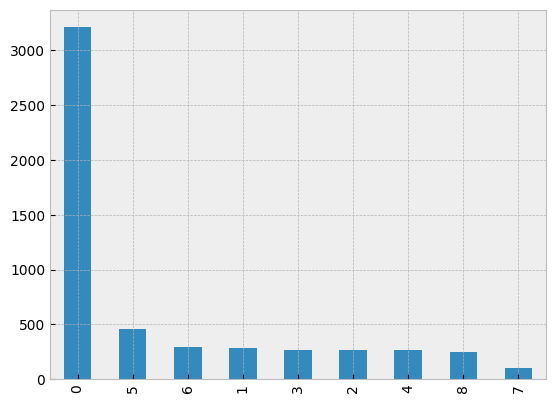

In [89]:
preds_test['class'].value_counts().plot(kind="bar");

### Исходный вид

In [90]:
y_test_preds = preds_test.copy()

# подготовим данные
y_test_preds[['sample_id', 'timestep']] = y_test_preds['sample-timestep'].str.split(pat='-',n=1, expand=True).astype(int)
y_test_preds = y_test_preds.pivot(index='sample_id', columns='timestep', values='class')
y_test_index = y_test.index
y_test_preds = y_test_preds.sort_index() # на всякий случай
y_test_preds = y_test_preds.values

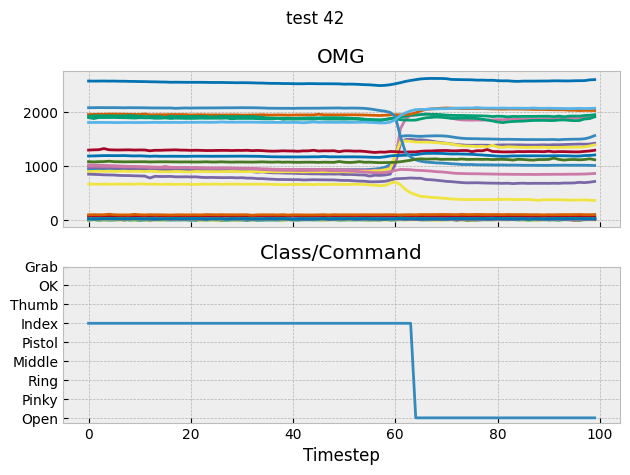

In [91]:
i = 42
fig, axx = plt.subplots(2, 1, sharex=True)

axx[0].plot(X_test[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_test_preds[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'test {i}')

plt.tight_layout()

Или сразу выведем панорамный вид.

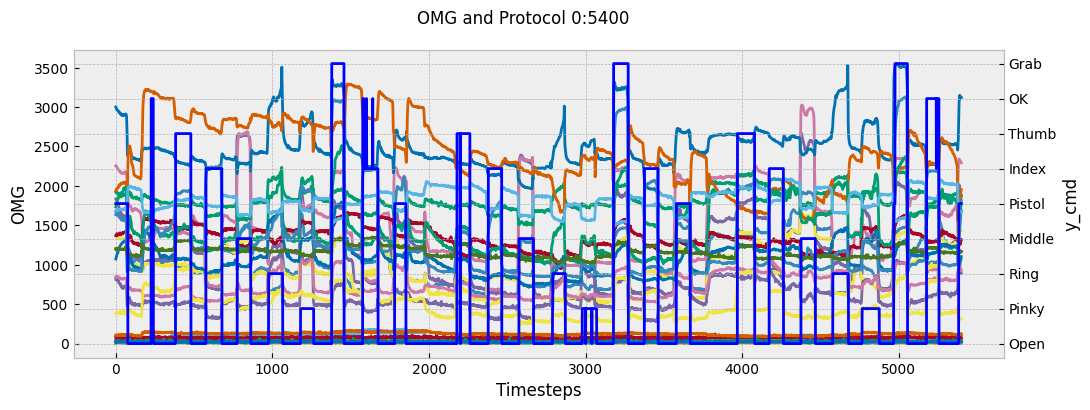

In [92]:
y_test_2d = y_test_preds.reshape(-1,)

get_graphs(X_test_2d, y_test_2d, start=0, end=X_test_2d.shape[0])

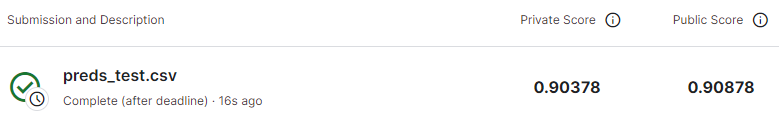